## 1. Load Pre-Processed Data

In [22]:
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.feature import Imputer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import functions as F

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
df = spark.read.parquet("gs://dsa5208-mllib-proj/processed/df_cleaned.parquet")

In [24]:
df.show(10, truncate=False)
df.count()

+-------+--------+---------+---------+-------+-------+---------+--------+----------+------------+
|tmp_cel|latitude|longitude|elevation|dew_cel|slp_hpa|wnd_speed|vis_dist|cig_height|date_numeric|
+-------+--------+---------+---------+-------+-------+---------+--------+----------+------------+
|7.4    |53.25   |4.9166667|5.0      |5.9    |992.0  |90.0     |13000.0 |780.0     |19723.0     |
|7.9    |53.25   |4.9166667|5.0      |4.9    |992.1  |110.0    |24000.0 |1440.0    |19723.0     |
|7.2    |53.25   |4.9166667|5.0      |5.9    |992.6  |70.0     |18000.0 |900.0     |19723.0     |
|8.1    |53.25   |4.9166667|5.0      |6.2    |992.5  |110.0    |15000.0 |1110.0    |19723.0     |
|7.9    |53.25   |4.9166667|5.0      |6.1    |992.8  |130.0    |6000.0  |1170.0    |19723.0     |
|8.3    |53.25   |4.9166667|5.0      |6.3    |993.0  |120.0    |6000.0  |900.0     |19723.0     |
|7.5    |53.25   |4.9166667|5.0      |5.8    |993.7  |110.0    |10000.0 |690.0     |19723.0     |
|8.2    |53.25   |4.

17953096

## 2. GLR Model Training

In [25]:
spark.sparkContext.setCheckpointDir("gs://dsa5208-mllib-proj/glr/spark_checkpoints/")

TARGET_COL = "tmp_cel"
FEATURE_COLS = [
    "latitude","longitude","elevation",
    "dew_cel","slp_hpa","wnd_speed","vis_dist","cig_height",
    "date_numeric"
]


In [26]:
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

In [27]:
#Pipeline: Imputer → VectorAssembler → GLR
imp_cols = [f"{c}__imp" for c in FEATURE_COLS]
imputer = Imputer(inputCols=FEATURE_COLS, outputCols=imp_cols, strategy="mean")
va = VectorAssembler(inputCols=imp_cols, outputCol="features")

glr = GeneralizedLinearRegression(
    labelCol=TARGET_COL,
    featuresCol="features",
    family="gaussian",      # we expect Gaussian to be the most appropriate as residuals are expected to follow a normal distribution, data is continuous, and can be < 0
    link="identity",        # classic multiple linear regression
    maxIter=100
)

pipeline = Pipeline(stages=[imputer, va, glr])

In [28]:
paramGrid = (ParamGridBuilder()
    .addGrid(glr.regParam, [0.0, 0.01, 0.1, 0.5])
    .addGrid(glr.maxIter, [50, 100])
    .build())

In [29]:
# Evaluator + CrossValidator (k-fold on TRAIN)
evaluator = RegressionEvaluator(labelCol=TARGET_COL, predictionCol="prediction", metricName="rmse")

cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,        # k-fold CV
    parallelism=4,    
    seed=42
)

In [30]:
cv_model  = cv.fit(train_df)
best_model = cv_model.bestModel

test_preds = best_model.transform(test_df)

rmse = evaluator.evaluate(test_preds)
r2   = RegressionEvaluator(labelCol=TARGET_COL, predictionCol="prediction", metricName="r2").evaluate(test_preds)
mae  = RegressionEvaluator(labelCol=TARGET_COL, predictionCol="prediction", metricName="mae").evaluate(test_preds)

print(f"[GLR + 5-fold CV] Test RMSE={rmse:.4f} | R2={r2:.4f} | MAE={mae:.4f}")

25/11/04 06:16:29 WARN Instrumentation: [94dce4eb] regParam is zero, which might cause numerical instability and overfitting.
25/11/04 06:16:34 WARN Instrumentation: [6595fb56] regParam is zero, which might cause numerical instability and overfitting.
25/11/04 06:18:00 WARN Instrumentation: [5a2b59d1] regParam is zero, which might cause numerical instability and overfitting.
25/11/04 06:18:04 WARN Instrumentation: [f8e72be1] regParam is zero, which might cause numerical instability and overfitting.
25/11/04 06:19:32 WARN Instrumentation: [58b70de5] regParam is zero, which might cause numerical instability and overfitting.
25/11/04 06:19:32 WARN Instrumentation: [f49c32f1] regParam is zero, which might cause numerical instability and overfitting.
25/11/04 06:20:56 WARN Instrumentation: [1cf2bc67] regParam is zero, which might cause numerical instability and overfitting.
25/11/04 06:20:58 WARN Instrumentation: [231340b2] regParam is zero, which might cause numerical instability and overf

[GLR + 5-fold CV] Test RMSE=5.2955 | R2=0.8221 | MAE=3.7526


In [31]:
best_glr = best_model.stages[-1]  # GeneralizedLinearRegressionModel
print("Best Params:")
print("  regParam:", best_glr._java_obj.getRegParam())
print("  maxIter :", best_glr._java_obj.getMaxIter())

Best Params:
  regParam: 0.0
  maxIter : 100


+--------------------+-----------------+------------------+-----------------+
|          mean_error|        std_error|         min_error|        max_error|
+--------------------+-----------------+------------------+-----------------+
|-0.00334055676754...|5.295492888897421|-78.51411989356775|26.85870092678494|
+--------------------+-----------------+------------------+-----------------+



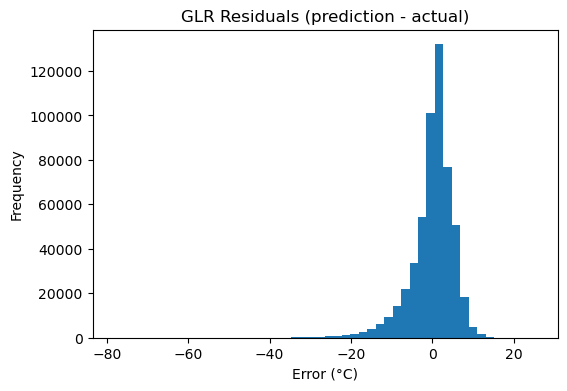

In [32]:
# Residual diagnostics - indicating that ther residuals follow a normal distribution (expected)
residuals = test_preds.withColumn("error", F.col("prediction") - F.col(TARGET_COL))
residuals.select(
    F.mean("error").alias("mean_error"),
    F.stddev("error").alias("std_error"),
    F.min("error").alias("min_error"),
    F.max("error").alias("max_error")
).show()

pdf = (residuals
       .select("prediction", TARGET_COL, "error")
       .sample(False, 0.1, seed=42)     # avoid collecting full test
       .toPandas())

plt.figure(figsize=(6,4))
plt.hist(pdf["error"], bins=50)
plt.title("GLR Residuals (prediction - actual)")
plt.xlabel("Error (°C)")
plt.ylabel("Frequency")
plt.show()

## Appendix - More Graphs

In [33]:
# === Coefficient "contribution" table (no pipeline changes) ===
from pyspark.sql import functions as F
import pandas as pd

# 1) Grab the fitted GLR from your best pipeline
glr_model = best_model.stages[-1]                 # GeneralizedLinearRegressionModel
betas = glr_model.coefficients.toArray()
intercept = glr_model.intercept

# 2) Map betas to original FEATURE_COLS order (VectorAssembler used imp_cols in the same order)
coef_df = pd.DataFrame({"feature": FEATURE_COLS, "beta": betas})

# 3) Compute per-feature std devs (on TRAIN, after imputation) and target std dev
#    (uses the imputer already fitted inside best_model)
imp_model = best_model.stages[0]                  # ImputerModel
train_imp = imp_model.transform(train_df)         # adds *_ _imp columns

# imp_cols must match what you used to build the VectorAssembler
# e.g., imp_cols = [f"{c}__imp" for c in FEATURE_COLS]
x_stats = (train_imp
           .select([F.stddev_pop(F.col(c)).alias(c) for c in imp_cols] +
                   [F.stddev_pop(F.col(TARGET_COL)).alias("_y_std")])
           .collect()[0]
           .asDict())

y_std = float(x_stats["_y_std"]) if x_stats["_y_std"] is not None else None

# 4) Build contribution metrics
#    - effect_per_1_unit: beta in original target units per +1 unit of X
#    - x_std: std dev of each predictor
#    - effect_per_1sd: beta * sd(X)  (change in target from +1 SD in X)
#    - standardized_beta: effect_per_1sd / sd(Y)  (unitless, comparable)
x_sd_series = []
eff_1sd_series = []
std_beta_series = []

for f in FEATURE_COLS:
    sd_x = float(x_stats.get(f + "__imp") or 0.0)
    x_sd_series.append(sd_x)
    eff_1sd = coef_df.loc[coef_df["feature"] == f, "beta"].values[0] * sd_x
    eff_1sd_series.append(eff_1sd)
    std_beta = (eff_1sd / y_std) if (y_std and y_std != 0) else None
    std_beta_series.append(std_beta)

coef_df["effect_per_1_unit"] = coef_df["beta"]                 # same as beta
coef_df["x_std"] = x_sd_series
coef_df["effect_per_1sd"] = eff_1sd_series
coef_df["standardized_beta"] = std_beta_series

# 5) Sort by most influential (absolute effect per 1 SD) and display
coef_df_sorted = coef_df.sort_values("effect_per_1sd", key=lambda s: s.abs(), ascending=False)

print(f"Intercept: {intercept:.4f}")
print(coef_df_sorted.to_string(index=False))


Intercept: 38.5097
     feature      beta  effect_per_1_unit        x_std  effect_per_1sd  standardized_beta
     dew_cel  0.950545           0.950545    11.500592       10.931830           0.870216
  cig_height  0.000237           0.000237 10225.492242        2.422889           0.192871
   elevation  0.003356           0.003356   432.999605        1.453218           0.115682
    latitude -0.047149          -0.047149    20.195673       -0.952212          -0.075800
   wnd_speed  0.025605           0.025605    25.560144        0.654475           0.052099
    vis_dist  0.000042           0.000042 11429.468716        0.483200           0.038465
     slp_hpa -0.047317          -0.047317     8.850753       -0.418794          -0.033338
date_numeric  0.000620           0.000620   106.035859        0.065744           0.005233
   longitude -0.000663          -0.000663    71.333884       -0.047271          -0.003763


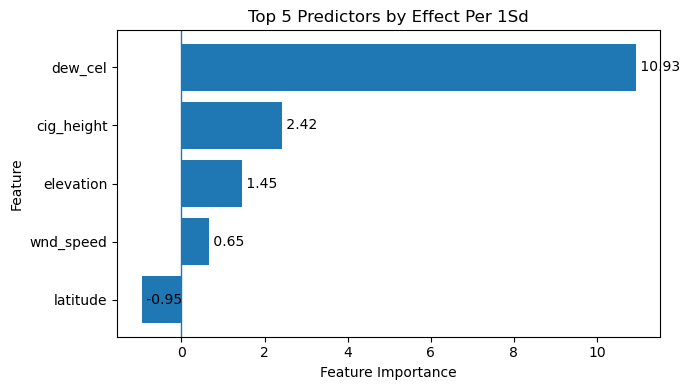

In [34]:
# === Top-5 predictors bar chart (by absolute effect_per_1sd) ===
metric = "effect_per_1sd"   # or "standardized_beta" if you prefer unitless comparison
top5 = (coef_df_sorted
        .assign(abs_metric=lambda d: d[metric].abs())
        .nlargest(5, "abs_metric")
        .sort_values(metric))   # sort so bars stack nicely bottom→top

plt.figure(figsize=(7,4))
plt.barh(top5["feature"], top5[metric])
plt.axvline(0, linewidth=1)
plt.title(f"Top 5 Predictors by {metric.replace('_', ' ').title()}")
plt.xlabel("Feature Importance")   
plt.ylabel("Feature")

for i, (v, f) in enumerate(zip(top5[metric], top5["feature"])):
    plt.text(v, i, f" {v:.2f}", va="center")  # label each bar with value

plt.tight_layout()
plt.show()

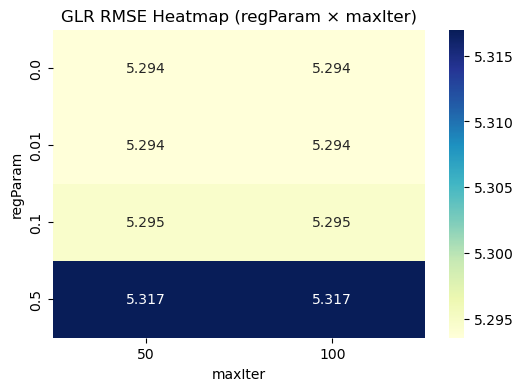

In [35]:
# Pull CV metrics and parameter combinations
metrics = cv_model.avgMetrics                # average RMSE across folds
params  = cv_model.getEstimatorParamMaps()   # each parameter set tried

# Build rows for plotting
rows = []
for m, p in zip(metrics, params):
    rows.append({
        "rmse": m,
        "regParam": p[glr.regParam],
        "maxIter":  p[glr.maxIter],
    })

df_glr = pd.DataFrame(rows)

# Pivot into matrix form (regParam × maxIter)
pivot = df_glr.pivot(index="regParam", columns="maxIter", values="rmse")

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("GLR RMSE Heatmap (regParam × maxIter)")
plt.ylabel("regParam")
plt.xlabel("maxIter")
plt.show()